In [1]:
!pip install pmdarima
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy.stats.mstats import zscore
xls = pd.ExcelFile('Ex4_data2.xlsx')
df1 = pd.read_excel(xls, '0005.HK')[['Date','Adj Close','Volume']]
df2 = pd.read_excel(xls, '0027.HK')[['Date','Adj Close','Volume']]
df3 = pd.read_excel(xls, '0101.HK')[['Date','Adj Close','Volume']]
HSI = pd.read_excel(xls, 'HSI')[['Date','Adj Close']]
DJI = pd.read_excel(xls, 'DJI')[['Date','Adj Close']]
SSEC = pd.read_excel(xls, 'SSEC')[['Date','Adj Close']]

df1_copy=df1.copy()
df2_copy=df2.copy()
df3_copy=df3.copy()
df1_copy['Date']=df1_copy['Date']+pd.Timedelta(days=1)# make Y t-1 date as a column
df2_copy['Date']=df2_copy['Date']+pd.Timedelta(days=1)
df3_copy['Date']=df3_copy['Date']+pd.Timedelta(days=1)
df1_copy.rename({'Adj Close': 'Pre Adj Close','Volume': 'Pre Volume'}, axis=1, inplace=True)
df2_copy.rename({'Adj Close': 'Pre Adj Close','Volume': 'Pre Volume'}, axis=1, inplace=True)
df3_copy.rename({'Adj Close': 'Pre Adj Close','Volume': 'Pre Volume'}, axis=1, inplace=True)


HSI.rename({'Adj Close': 'HSI Adj Close'}, axis=1, inplace=True)
DJI.rename({'Adj Close': 'DJI Adj Close'}, axis=1, inplace=True)
SSEC.rename({'Adj Close': 'SSEC Adj Close'}, axis=1, inplace=True)

df = (df1,df2,df3)
stk_name=['HSBC','Galaxy','Hang Lung','HSI','DJI','SSEC']
df1_copy.head()

,Date,Pre Adj Close,Pre Volume
0,2000-01-04,53.067974,3908164.0
1,2000-01-05,52.085232,6895378.0
2,2000-01-06,49.382702,14657098.0
3,2000-01-07,47.662907,10632084.0
4,2000-01-08,49.382702,8368286.0


In [2]:
#linear interpolate
for i in df:
    for n in list(i.columns):
        if (i[n].isnull().values.any()):
            i[n]=i[n].interpolate(method='linear')
    print(i.dtypes)

Date         datetime64[ns]
Adj Close           float64
Volume              float64
dtype: object
Date         datetime64[ns]
Adj Close           float64
Volume              float64
dtype: object
Date         datetime64[ns]
Adj Close           float64
Volume              float64
dtype: object


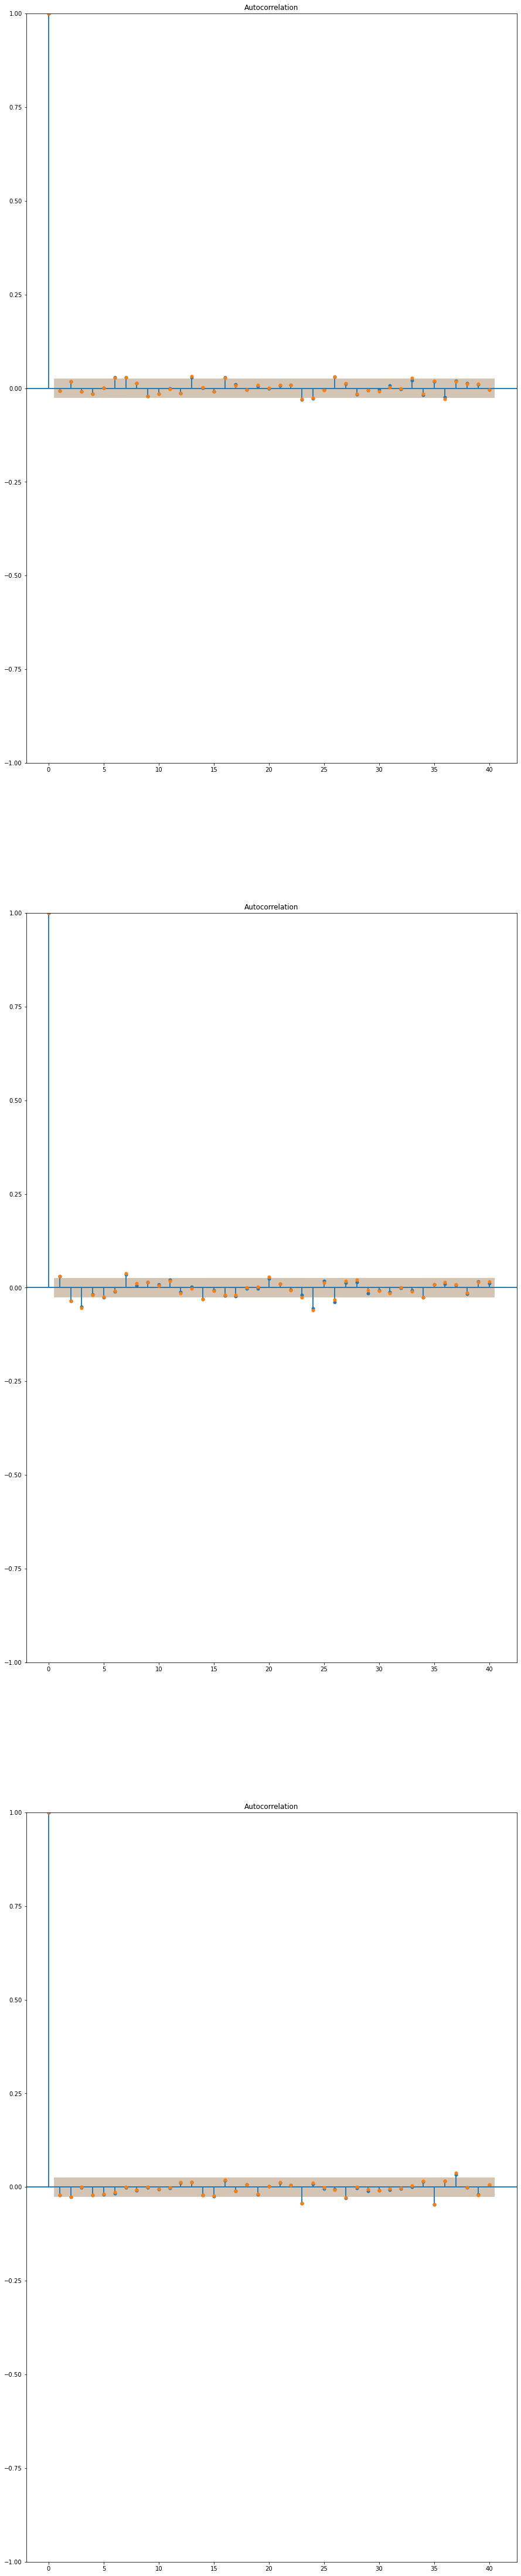

In [3]:
#show acf and pacf for each stock
fig2, axs2 = plt.subplots(3, figsize=(15,80))
for n,i in enumerate(df):
    plot_pacf(i['Adj Close'].diff().dropna(),lags = 40 , ax=axs2[n],method='ywm')
    plot_acf(i['Adj Close'].diff().dropna(),lags = 40 , ax=axs2[n])
    if n>=2: break


In [4]:
#merge all data to a dataframe
df1=pd.merge(df1,HSI,on='Date',how='left')
df1=pd.merge(df1,DJI,on='Date',how='left')
df1=pd.merge(df1,SSEC,on='Date',how='left')
df1=pd.merge(df1,df1_copy,on='Date',how='left')

df2=pd.merge(df2,HSI,on='Date',how='left')
df2=pd.merge(df2,DJI,on='Date',how='left')
df2=pd.merge(df2,SSEC,on='Date',how='left')
df2=pd.merge(df2,df2_copy,on='Date',how='left')

df3=pd.merge(df3,HSI,on='Date',how='left')
df3=pd.merge(df3,DJI,on='Date',how='left')
df3=pd.merge(df3,SSEC,on='Date',how='left')
df3=pd.merge(df3,df3_copy,on='Date',how='left')

df1.head(10)


,Date,Adj Close,Volume,HSI Adj Close,DJI Adj Close,SSEC Adj Close,Pre Adj Close,Pre Volume
0,2000-01-03,53.067974,3908164.0,17369.630859,11357.509766,NaN,NaN,NaN
1,2000-01-04,52.085232,6895378.0,17072.820313,10997.929688,1406.370972,53.067974,3908164.0
2,2000-01-05,49.382702,14657098.0,15846.719727,11122.650391,1409.682007,52.085232,6895378.0
3,2000-01-06,47.662907,10632084.0,15153.230469,11253.259766,1463.942017,49.382702,14657098.0
4,2000-01-07,49.382702,8368286.0,15405.629883,11522.559570,1516.604004,47.662907,10632084.0
5,2000-01-10,49.137001,6201139.0,15848.150391,11572.200195,1545.112061,NaN,NaN
6,2000-01-11,48.154278,8366294.0,15862.099609,11511.080078,1479.781006,49.137001,6201139.0
7,2000-01-12,47.294399,7369722.0,15714.200195,11551.099609,1438.020020,48.154278,8366294.0
8,2000-01-13,47.540051,5281865.0,15633.959961,11582.429688,1424.442017,47.294399,7369722.0
9,2000-01-14,47.540051,5930363.0,15542.230469,11722.980469,1408.848022,47.540051,5281865.0


In [5]:
#linear interpolate for differences of not exchange day for different market
df = (df1,df2,df3)
for i in df:
    for n in list(i.columns):

        if (i[n].isnull().values.any()):
            i[n]=i[n].interpolate(method='linear')
            

#add dummy variable for month as IV
df1['weekday']= df1['Date'].dt.strftime('%A')
df2['weekday']= df2['Date'].dt.strftime('%A')
df3['weekday']= df3['Date'].dt.strftime('%A')
print(df3)

df1=pd.get_dummies(df1).drop(columns=['weekday_Monday'])
df2=pd.get_dummies(df2).drop(columns=['weekday_Monday'])
df3=pd.get_dummies(df3).drop(columns=['weekday_Monday'])

# drop the first row because it dont have perivous price and volume
df1 = df1.iloc[1:]
df2 = df2.iloc[1:]
df3 = df3.iloc[1:]

df1

           Date  Adj Close     Volume  HSI Adj Close  DJI Adj Close  \
0    2000-01-04   2.718446  2512000.0   17072.820313   10997.929688   
1    2000-01-05   2.569781  3362000.0   15846.719727   11122.650391   
2    2000-01-06   2.527305  3758500.0   15153.230469   11253.259766   
3    2000-01-07   2.569781  2794500.0   15405.629883   11522.559570   
4    2000-01-10   2.569781  2095006.0   15848.150391   11572.200195   
...         ...        ...        ...            ...            ...   
5777 2023-02-15  15.780000  5773820.0   20812.169922   34128.050000   
5778 2023-02-16  16.020000  6817863.0   20987.669922   33696.850000   
5779 2023-02-17  15.900000  3081556.0   20719.810547   33826.690000   
5780 2023-02-20  16.040001  2733432.0   20886.960938   33478.140000   
5781 2023-02-21  16.100000  2887989.0   20529.490234   33129.590000   

      SSEC Adj Close  Pre Adj Close  Pre Volume    weekday  
0        1406.370972            NaN         NaN    Tuesday  
1        1409.682007     

,Date,Adj Close,Volume,HSI Adj Close,DJI Adj Close,SSEC Adj Close,Pre Adj Close,Pre Volume,weekday_Friday,weekday_Saturday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
1,2000-01-04,52.085232,6895378.0,17072.820313,10997.929688,1406.370972,53.067974,3908164.0,0,0,0,1,0
2,2000-01-05,49.382702,14657098.0,15846.719727,11122.650391,1409.682007,52.085232,6895378.0,0,0,0,0,1
3,2000-01-06,47.662907,10632084.0,15153.230469,11253.259766,1463.942017,49.382702,14657098.0,0,0,1,0,0
4,2000-01-07,49.382702,8368286.0,15405.629883,11522.559570,1516.604004,47.662907,10632084.0,1,0,0,0,0
5,2000-01-10,49.137001,6201139.0,15848.150391,11572.200195,1545.112061,48.399954,8416611.5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5778,2023-02-15,57.549999,16059738.0,20812.169922,34128.050000,3280.489990,58.200001,16289619.0,0,0,0,0,1
5779,2023-02-16,58.099998,12427999.0,20987.669922,33696.850000,3249.030029,57.549999,16059738.0,0,0,1,0,0
5780,2023-02-17,58.200001,15946227.0,20719.810547,33826.690000,3224.020020,58.099998,12427999.0,1,0,0,0,0
5781,2023-02-20,58.750000,18946483.0,20886.960938,33478.140000,3290.340088,58.424999,15687241.0,0,0,0,0,0


In [6]:
#split data as train set and test set
dt=dt.datetime(2022, 12, 31)

df1.drop(df1[df1['weekday_Saturday'] ==1].index, inplace=True)
df1=df1.drop(['weekday_Saturday'],axis=1)
df2.drop(df2[df2['weekday_Saturday'] ==1].index, inplace=True)
df2=df2.drop(['weekday_Saturday'],axis=1)
df3.drop(df3[df3['weekday_Saturday'] ==1].index, inplace=True)
df3=df3.drop(['weekday_Saturday'],axis=1)

df1.set_index('Date',inplace=True)
df2.set_index('Date',inplace=True)
df3.set_index('Date',inplace=True)
train_df1 = df1.drop(df1[df1.index>=dt].index)
test_df1 = df1.drop(df1[df1.index<dt].index)
train_df2 = df2.drop(df2[df2.index>=dt].index)
test_df2 = df2.drop(df2[df2.index<dt].index)
train_df3 = df3.drop(df3[df3.index>=dt].index)
test_df3 = df3.drop(df3[df3.index<dt].index)

train_df2=train_df2.reset_index()
test_df2=test_df2.reset_index()

#MAPE Formula
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape




In [7]:
# HSBC


train_df1X=train_df1.drop(['Adj Close','Volume','Pre Volume','DJI Adj Close','SSEC Adj Close'],axis=1)
train_df1y=train_df1.loc[:,'Adj Close']
test_df1X=test_df1.drop(['Adj Close','Volume','Pre Volume','DJI Adj Close','SSEC Adj Close'],axis=1)
test_df1y=test_df1.loc[:,'Adj Close']

print(sm.OLS(train_df1y, train_df1X).fit().summary())

predict_y=sm.OLS(train_df1y, train_df1X).fit().predict(train_df1X)
print(MAPE(predict_y,train_df1y))

predict_y=sm.OLS(train_df1y, train_df1X).fit().predict(test_df1X)
print(MAPE(predict_y,test_df1y))

                                 OLS Regression Results                                
Dep. Variable:              Adj Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.002e+06
Date:                Tue, 07 Mar 2023   Prob (F-statistic):                        0.00
Time:                        21:03:37   Log-Likelihood:                         -5946.2
No. Observations:                5747   AIC:                                  1.190e+04
Df Residuals:                    5741   BIC:                                  1.194e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [8]:
# Hang Lung


train_df3X=train_df3.drop(['Adj Close','Volume','Pre Volume','DJI Adj Close','SSEC Adj Close'],axis=1)
train_df3y=train_df3.loc[:,'Adj Close']
test_df3X=test_df3.drop(['Adj Close','Volume','Pre Volume','DJI Adj Close','SSEC Adj Close'],axis=1)
test_df3y=test_df3.loc[:,'Adj Close']

print(sm.OLS(train_df3y, train_df3X).fit().summary())

predict_y=sm.OLS(train_df3y, train_df3X).fit().predict(train_df3X)
print(MAPE(predict_y,train_df3y))

predict_y=sm.OLS(train_df3y, train_df3X).fit().predict(test_df3X)
print(MAPE(predict_y,test_df3y))

                                 OLS Regression Results                                
Dep. Variable:              Adj Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.731e+06
Date:                Tue, 07 Mar 2023   Prob (F-statistic):                        0.00
Time:                        21:03:37   Log-Likelihood:                         -449.26
No. Observations:                5746   AIC:                                      910.5
Df Residuals:                    5740   BIC:                                      950.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [9]:
# Galaxy



train_df2X=train_df2.drop(['Adj Close','Volume','HSI Adj Close','DJI Adj Close','Pre Volume','Date','Pre Adj Close'],axis=1)
train_df2y=train_df2.loc[:,'Adj Close']
test_df2X=test_df2.drop(['Adj Close','Volume','HSI Adj Close','DJI Adj Close','Pre Volume','Date','Pre Adj Close'],axis=1)
test_df2y=test_df2.loc[:,'Adj Close']


model = sm.tsa.arima.ARIMA(train_df2y, order = (3,1,3),exog=train_df2X)
model_fit = model.fit()
print(model_fit.summary())

predict_y=model_fit.predict(start=0,end=-1,exog=train_df2X)
print(MAPE(predict_y,train_df2y))

predict_y=model_fit.predict(start=0,end=-1,exog=test_df2X)
print(MAPE(predict_y,test_df2y))


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5746
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -6635.126
Date:                Tue, 07 Mar 2023   AIC                          13294.252
Time:                        21:03:41   BIC                          13374.125
Sample:                             0   HQIC                         13322.050
                               - 5746                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
SSEC Adj Close        0.0036      0.000     21.029      0.000       0.003       0.004
weekday_Friday        0.0687      0.020      3.513      0.000       0.030       0.107
weekday_Thursday      0.

In [10]:
from pmdarima.arima import auto_arima
model_auto=auto_arima(df1['HSI Adj Close'])
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5780
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -40955.681
Date:                Tue, 07 Mar 2023   AIC                          81921.361
Time:                        21:04:08   BIC                          81954.671
Sample:                             0   HQIC                         81932.950
                               - 5780                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0734      0.023      3.242      0.001       0.029       0.118
ar.L2         -0.9422      0.023    -41.476      0.000      -0.987      -0.898
ma.L1         -0.0837      0.026     -3.260      0.001      -0.134      -0.033
ma.L2          0.9287      0.025     36.775      0.000       0.879       0.978
sigma2      8.376e+04    856.018     97.844      0.000    8.21e+04    8.54e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):              5263.43
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               3.29   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
#extrapolate for HSI
model = sm.tsa.arima.ARIMA(df1.reset_index()['HSI Adj Close'], order = (2,1,2))
model_fit = model.fit()
fore_set=model_fit.forecast(18).to_frame()
fore_set.rename({'predicted_mean': 'HSI Adj Close'}, axis=1, inplace=True)
fore_set

,HSI Adj Close
5780,20517.976651
5781,20531.108520
5782,20542.921083
5783,20531.415657
5784,20519.440838
5785,20529.401903
5786,20541.416185
5787,20532.913124
5788,20520.968734
5789,20528.103187


In [12]:
from pmdarima.arima import auto_arima
model_auto=auto_arima(df1['SSEC Adj Close'])
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5780
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -29936.217
Date:                Tue, 07 Mar 2023   AIC                          59886.433
Time:                        21:05:08   BIC                          59933.067
Sample:                             0   HQIC                         59902.658
                               - 5780                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5951      0.067      8.892      0.000       0.464       0.726
ar.L2         -0.9196      0.020    -45.397      0.000      -0.959      -0.880
ar.L3          0.4054      0.063      6.440      0.000       0.282       0.529
ma.L1         -0.5646      0.069     -8.146      0.000      -0.700      -0.429
ma.L2          0.8816      0.024     36.897      0.000       0.835       0.928
ma.L3         -0.3220      0.064     -5.004      0.000      -0.448      -0.196
sigma2      1848.7764     13.572    136.220      0.000    1822.176    1875.377
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             33963.60
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
#extrapolate for SSEC
model = sm.tsa.arima.ARIMA(df1.reset_index()['SSEC Adj Close'], order = (3,1,3))
model_fit = model.fit()
fore_set['SSEC Adj Close']=model_fit.forecast(18).to_frame()
fore_set

,HSI Adj Close,SSEC Adj Close
5780,20517.976651,3302.318376
5781,20531.108520,3305.334201
5782,20542.921083,3312.134778
5783,20531.415657,3311.703348
5784,20519.440838,3306.415850
5785,20529.401903,3306.423362
5786,20541.416185,3311.115039
5787,20532.913124,3311.756241
5788,20520.968734,3307.826603
5789,20528.103187,3306.800770


In [14]:
fore_set1=fore_set.copy()
fore_set2=fore_set.copy()
fore_set3=fore_set.copy()
set1=[]
set1.append(df1['Pre Adj Close'].iloc[-1])
set3=[]
set3.append(df3['Pre Adj Close'].iloc[-1])
for i in range(len(fore_set)-1):
    set1.append(0)
    set3.append(0)

fore_set1['Pre Adj Close']=set1
fore_set3['Pre Adj Close']=set3
fore_set1=fore_set1.drop(['SSEC Adj Close'],axis=1)
fore_set3=fore_set3.drop(['SSEC Adj Close'],axis=1)
fore_set1


weekday=('Wednesday','Thursday','Friday','Monday','Tueday')
lis=[]
for i in range(len(fore_set)):
    lis.append(weekday[i%5])
ser=pd.Series(lis)
fore_set1['weekday']=pd.Series(lis).values
fore_set1=pd.get_dummies(fore_set1).drop(columns=['weekday_Monday'])

weekday=('Wednesday','Thursday','Friday','Monday','Tueday')
lis=[]
for i in range(len(fore_set)):
    lis.append(weekday[i%5])
ser=pd.Series(lis)
fore_set3['weekday']=pd.Series(lis).values
fore_set3=pd.get_dummies(fore_set3).drop(columns=['weekday_Monday'])

In [15]:
#forecast for HSBC

df1X=df1.drop(['Adj Close','Volume','Pre Volume','DJI Adj Close','SSEC Adj Close'],axis=1)
df1y=df1.loc[:,'Adj Close']

In [16]:
for i in range(18):
    predict_y=sm.OLS(df1y,df1X).fit().predict(fore_set1.iloc[[i]])
    if(i<17): fore_set1['Pre Adj Close'].iloc[i+1]=predict_y
    print(predict_y)

5780    58.752387
dtype: float64
5781    58.75936
dtype: float64
5782    58.763912
dtype: float64
5783    58.737841
dtype: float64
5784    58.730266
dtype: float64
5785    58.73271
dtype: float64
5786    58.739737
dtype: float64
5787    58.744289
dtype: float64
5788    58.718218
dtype: float64
5789    58.710692
dtype: float64
5790    58.71319
dtype: float64
5791    58.720224
dtype: float64
5792    58.724776
dtype: float64
5793    58.698747
dtype: float64
5794    58.691275
dtype: float64
5795    58.693786
dtype: float64
5796    58.70082
dtype: float64
5797    58.705408
dtype: float64


C:\Users\marcowong\AppData\Local\Temp\ipykernel_10680\38654770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if(i<17): fore_set1['Pre Adj Close'].iloc[i+1]=predict_y


In [17]:
#forecast for Galaxy
df3X=df3.drop(['Adj Close','Volume','Pre Volume','DJI Adj Close','SSEC Adj Close'],axis=1)
df3y=df3.loc[:,'Adj Close']

In [18]:
for i in range(18):
    predict_y=sm.OLS(df3y,df3X).fit().predict(fore_set1.iloc[[i]])
    if(i<17): fore_set3['Pre Adj Close'].iloc[i+1]=predict_y
    print(predict_y)

5780    58.592248
dtype: float64
5781    58.581573
dtype: float64
5782    58.596068
dtype: float64
5783    58.604383
dtype: float64
5784    58.568578
dtype: float64
5785    58.572618
dtype: float64
5786    58.561996
dtype: float64
5787    58.57649
dtype: float64
5788    58.584804
dtype: float64
5789    58.54905
dtype: float64
5790    58.553144
dtype: float64
5791    58.542528
dtype: float64
5792    58.55702
dtype: float64
5793    58.565379
dtype: float64
5794    58.529679
dtype: float64
5795    58.533784
dtype: float64
5796    58.523167
dtype: float64
5797    58.537698
dtype: float64


C:\Users\marcowong\AppData\Local\Temp\ipykernel_10680\216634474.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if(i<17): fore_set3['Pre Adj Close'].iloc[i+1]=predict_y


In [20]:
#forecast for Hang Lung
df2X=df2.drop(['Adj Close','Volume','HSI Adj Close','DJI Adj Close','Pre Volume','Pre Adj Close'],axis=1)
df2y=df2.loc[:,'Adj Close']

In [21]:
fore_set2=fore_set.copy()
fore_set2=fore_set2.drop(['HSI Adj Close'],axis=1)
df2X=df2X.reset_index().drop(['Date'],axis=1)

weekday=('Wednesday','Thursday','Friday','Monday','Tueday')
lis=[]
for i in range(len(fore_set)):
    lis.append(weekday[i%5])
ser=pd.Series(lis)
fore_set2['weekday']=pd.Series(lis).values
fore_set2=pd.get_dummies(fore_set2).drop(columns=['weekday_Monday'])

In [34]:
df2X.reset_index()

,index,SSEC Adj Close,weekday_Friday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,1409.682007,0,0,0,1
1,1,1463.942017,0,1,0,0
2,2,1516.604004,1,0,0,0
3,3,1545.112061,0,0,0,0
4,4,1479.781006,0,0,1,0
...,...,...,...,...,...,...
5774,5774,3280.489990,0,0,0,1
5775,5775,3249.030029,0,1,0,0
5776,5776,3224.020020,1,0,0,0
5777,5777,3290.340088,0,0,0,0


In [36]:
model = sm.tsa.arima.ARIMA(df2y.reset_index()['Adj Close'], order = (3,1,3),exog=df2X)
model_fit = model.fit()
predict_y=model_fit.predict(start=5779,end=5796,exog=fore_set2)
print(predict_y)

5779    51.688937
5780    51.754473
5781    51.799552
5782    51.734540
5783    51.754701
5784    51.771019
5785    51.796859
5786    51.800584
5787    51.720270
5788    51.756003
5789    51.784228
5790    51.797734
5791    51.789518
5792    51.718240
5793    51.765326
5794    51.787155
5795    51.790080
5796    51.786051
Name: predicted_mean, dtype: float64
